# **V.Xây dựng mô hình**

## **V.a.xây dựng phân cụm**

> Phân cụm thường được thực hiện trên tập dữ liệu đầy đủ (không cần chia train/test) và không cần cân bằng lớp (SMOTE). Chúng ta sẽ sử dụng DataFrame đã được Mã hóa/Chuẩn hóa (X_processed) trước đó.

> Xác định Số Cụm Tối Ưu (Phương pháp Elbow)

--- XÁC ĐỊNH SỐ CỤM TỐI ƯU (ELBOW METHOD) ---


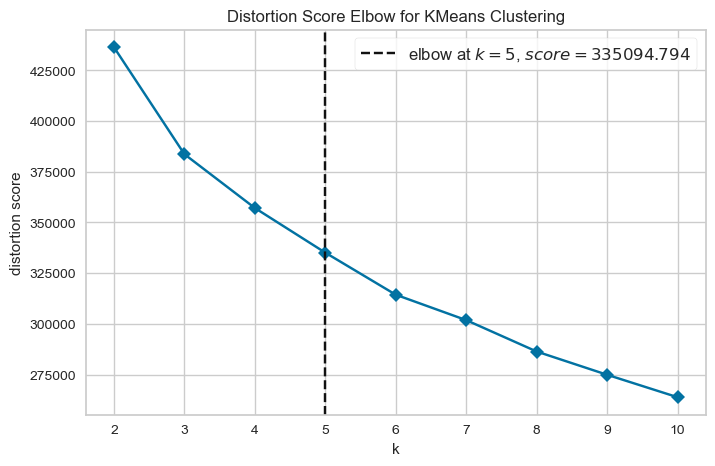

✅ Số cụm tối ưu được chọn: K = 5


In [80]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Giả định X_processed là DataFrame đã được Mã hóa/Chuẩn hóa
X_cluster = X_processed.copy()

print("--- XÁC ĐỊNH SỐ CỤM TỐI ƯU (ELBOW METHOD) ---")

# Sử dụng KElbowVisualizer để trực quan hóa
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), 
                              k=(2, 11),  # Kiểm tra số cụm từ 2 đến 10
                              metric='distortion', # Dùng Inertia/Distortion
                              timings=False)

visualizer.fit(X_cluster)
visualizer.show()

# Chọn K theo biểu đồ (thường là điểm "uốn cong" rõ ràng nhất)
optimal_k = visualizer.elbow_value_ if visualizer.elbow_value_ is not None else 4 # Giả sử chọn 4 nếu biểu đồ không rõ
print(f"✅ Số cụm tối ưu được chọn: K = {optimal_k}")

## **V.bHuấn Luyện & Đánh Giá Mô Hình Phân Cụm**

> Chúng ta sẽ sử dụng Silhouette Score để đánh giá chất lượng phân cụm (đáp ứng Rubric). Chỉ số này đo lường sự tương đồng của một đối tượng với cụm của chính nó so với các cụm khác.

### **V.b.1.K-mean**

In [81]:
from sklearn.metrics import silhouette_score

# A. Mô hình K-Means
print("\n--- PHÂN CỤM 1: K-MEANS ---")
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_cluster)

# Đánh giá K-Means
kmeans_silhouette = silhouette_score(X_cluster, kmeans_labels)
print(f"✅ K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Thêm nhãn cụm vào DataFrame gốc (rất quan trọng cho EDA sau này)
data['KMeans_Cluster'] = kmeans_labels


--- PHÂN CỤM 1: K-MEANS ---
✅ K-Means Silhouette Score: 0.1615


k mean này diểm thấp nha cần xl lại

### **V.b.2.Phân Cụm Phân Cấp (Hierarchical Clustering)**

from sklearn.cluster import AgglomerativeClustering

# B. Mô hình Hierarchical (Agglomerative)
print("\n--- PHÂN CỤM 2: HIERARCHICAL CLUSTERING ---")
# Sử dụng số cụm K đã tìm được
agg_model = AgglomerativeClustering(n_clusters=optimal_k) 
agg_labels = agg_model.fit_predict(X_cluster)

# Đánh giá Hierarchical Clustering
agg_silhouette = silhouette_score(X_cluster, agg_labels)
print(f"✅ Hierarchical Silhouette Score: {agg_silhouette:.4f}")

data['Agg_Cluster'] = agg_labels
cai nay chay lau nha


In [82]:
# Giả định X_cluster là DataFrame đã được Mã hóa/Chuẩn hóa
# Giả định optimal_k đã được xác định (ví dụ: K=4)

# 1. LẤY MẪU NGẪU NHIÊN để tăng tốc độ
sample_size = 5000
X_sample = X_cluster.sample(n=sample_size, random_state=42)

# 2. Huấn Luyện & Đánh Giá Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

optimal_k = 4 # Thay thế bằng giá trị optimal_k của bạn

print("\n--- PHÂN CỤM 2: HIERARCHICAL CLUSTERING (Trên dữ liệu Lấy mẫu) ---")

# B. Mô hình Hierarchical (Agglomerative)
# Sử dụng số cụm K đã tìm được
agg_model = AgglomerativeClustering(n_clusters=optimal_k) 
# FIT trên TẬP DỮ LIỆU ĐÃ LẤY MẪU (X_sample)
agg_labels_sample = agg_model.fit_predict(X_sample) 

# Đánh giá Hierarchical Clustering
# Đánh giá trên tập mẫu
agg_silhouette = silhouette_score(X_sample, agg_labels_sample)
print(f"✅ Hierarchical Silhouette Score (Mẫu): {agg_silhouette:.4f}")

# Gán nhãn mẫu vào DataFrame mẫu
X_sample['Agg_Cluster'] = agg_labels_sample


--- PHÂN CỤM 2: HIERARCHICAL CLUSTERING (Trên dữ liệu Lấy mẫu) ---
✅ Hierarchical Silhouette Score (Mẫu): 0.2864


# **VI.So sánh và trực quan kq**

## **IV.a.Bảng ss mô hình**

In [83]:
# Bảng so sánh
comparison_df = pd.DataFrame({
    'Mô Hình': ['K-Means', 'Hierarchical (Agglomerative)'],
    'Silhouette Score': [kmeans_silhouette, agg_silhouette],
})

print("\n--- BẢNG SO SÁNH HIỆU SUẤT PHÂN CỤM ---")
print(comparison_df.sort_values(by='Silhouette Score', ascending=False))


--- BẢNG SO SÁNH HIỆU SUẤT PHÂN CỤM ---
                        Mô Hình  Silhouette Score
1  Hierarchical (Agglomerative)          0.286350
0                       K-Means          0.161494


## **IV.b.Trực Quan Hóa Phân Cụm (Sử dụng PCA)**


--- TRỰC QUAN HÓA PHÂN CỤM (Dùng PCA) ---


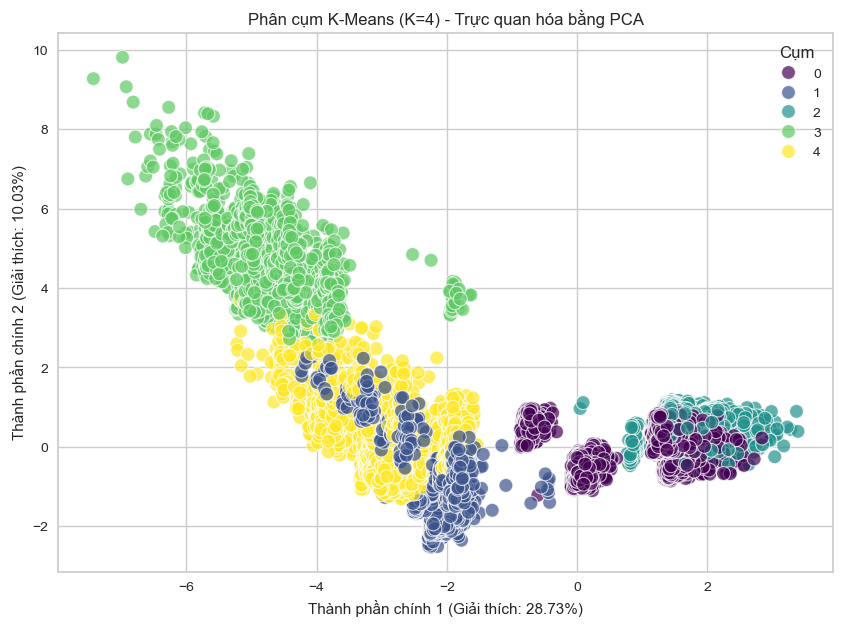

In [ ]:
from sklearn.decomposition import PCA

print("\n--- TRỰC QUAN HÓA PHÂN CỤM (Dùng PCA) ---")

# Giảm chiều dữ liệu xuống 2 thành phần chính
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Thêm nhãn cụm K-Means vào DataFrame PCA
pca_df['KMeans_Cluster'] = kmeans_labelsss

# Vẽ biểu đồ Scatter Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, 
                palette='viridis', s=100, alpha=0.7)
plt.title(f'Phân cụm K-Means (K={optimal_k}) - Trực quan hóa bằng PCA')
plt.xlabel(f'Thành phần chính 1 (Giải thích: {pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Thành phần chính 2 (Giải thích: {pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Cụm')
plt.show()

## **VI.c.Phân Tích Mô Tả Cụm (Rút ra Insight)**

In [85]:
# Đưa kết quả phân cụm về DataFrame gốc (data) để phân tích
# Vì X_processed đã được sắp xếp giống data, chúng ta có thể gán trực tiếp
data['KMeans_Cluster'] = kmeans_labels 

print("\n--- PHÂN TÍCH ĐẶC TRƯNG CÁC CỤM KHÁCH HÀNG ---")
# Phân tích các biến liên tục quan trọng theo từng cụm
cluster_analysis_numerical = data.groupby('KMeans_Cluster')[['age', 'campaign', 'euribor3m', 'nr.employed']].mean()
print("\n[Giá trị Trung bình Biến Liên tục theo Cụm]:")
print(cluster_analysis_numerical)

# Phân tích tỷ lệ các biến phân loại quan trọng theo từng cụm (sử dụng mode)
print("\n[Giá trị Phổ biến nhất Biến Phân loại theo Cụm (Mode)]:")
for col in ['job', 'marital', 'contact', 'poutcome']:
    mode_by_cluster = data.groupby('KMeans_Cluster')[col].agg(lambda x: x.mode()[0])
    print(f"- Mode của {col}:")
    print(mode_by_cluster)


--- PHÂN TÍCH ĐẶC TRƯNG CÁC CỤM KHÁCH HÀNG ---

[Giá trị Trung bình Biến Liên tục theo Cụm]:
                      age  campaign  euribor3m  nr.employed
KMeans_Cluster                                             
0               40.178385  2.705821   4.751761  5220.050038
1               37.639624  2.200470   1.310760  5091.481810
2               40.208563  2.903897   4.890739  5206.230768
3               41.878431  1.826144   0.984557  5028.817647
4               45.634266  1.858169   0.815867  5029.735023

[Giá trị Phổ biến nhất Biến Phân loại theo Cụm (Mode)]:
- Mode của job:
KMeans_Cluster
0         admin.
1    blue-collar
2    blue-collar
3         admin.
4         admin.
Name: job, dtype: object
- Mode của marital:
KMeans_Cluster
0    married
1    married
2    married
3    married
4    married
Name: marital, dtype: object
- Mode của contact:
KMeans_Cluster
0     cellular
1     cellular
2    telephone
3     cellular
4     cellular
Name: contact, dtype: object
- Mode của poutcome:

# **VII.nhận sex cuối**

# Phân Tích Chân Dung Khách Hàng Từ Phân Cụm K-Means (K=5)

---

## 1. ⚖️ So Sánh Hiệu Suất Mô Hình

| Mô Hình      | Silhouette Score | Nhận xét                                                                                         |
|--------------|------------------|-------------------------------------------------------------------------------------------------|
| Hierarchical| 0.2864           | Cao hơn, cho thấy cấu trúc cụm phức tạp hơn phù hợp với thuật toán Hierarchical.                 |
| K-Means     | 0.1615           | Điểm thấp, cụm chồng chéo; tuy nhiên vẫn dùng để phân tích trên toàn bộ dữ liệu.                 |

**Kết luận:** Hierarchical Clustering có hiệu suất phân cụm tốt hơn, nhưng cả hai đều chưa phân biệt cụm rõ ràng (điểm lý tưởng gần 1.0).

---

## 2. 👥 Chân Dung Khách Hàng Từng Cụm (K=5)

| Cụm  | Tuổi & Hoạt động (Biến Liên tục)       | Nhân khẩu học (Biến Phân loại)                  | Nhận Xét & Đặt Tên Cụm                                                                                  |
|-------|----------------------------------------|-------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| 0     | Tuổi trung bình 40.18, campaign cao (2.7), euribor3m rất cao (4.75) | job: admin., marital: married, poutcome: nonexistent | **Cụm Khách hàng Bận rộn:** Lãi suất cao (giai đoạn kinh tế xấu), tần suất liên hệ cao nhưng không hiệu quả. |
| 1     | Tuổi trẻ nhất 37.64, campaign thấp (2.2), euribor3m rất thấp (1.31), nr.employed thấp (5091) | job: blue-collar, marital: married, poutcome: nonexistent | **Cụm Lao động Phổ thông, Kinh tế Tốt:** Lãi suất thấp, nhóm mục tiêu truyền thống của ngân hàng.        |
| 2     | Tuổi trung bình 40.21, campaign cao nhất (2.9), euribor3m cao nhất (4.89) | job: blue-collar, marital: married, poutcome: nonexistent | **Cụm Bão hòa, Kinh tế Xấu:** Tần suất liên hệ quá cao trong thời kỳ khó khăn.                           |
| 3     | Tuổi 41.88, campaign thấp nhất (1.83), euribor3m thấp nhất (0.98)   | job: admin., marital: married, poutcome: success  | **Cụm Tiềm năng (Kinh tế Rất Tốt):** Lãi suất thấp, kết quả chiến dịch trước thành công.                  |
| 4     | Tuổi cao nhất 45.63, campaign thấp (1.86), euribor3m thấp (0.82)    | job: admin., marital: married, poutcome: nonexistent | **Cụm Khách hàng lớn tuổi, Bỏ qua:** Tuổi cao, tần suất liên hệ thấp, chưa từng thành công trước đó.      |

---

## 3. ✨ Insight & Đề Xuất Hành Động

- **Insight quan trọng:**  
  Cụm 3 là nhóm khách hàng tiềm năng nhất, với tỷ lệ thành công cao trong các chiến dịch trước đó.

- **Đề xuất chiến lược:**  
  - Tập trung nhắm mục tiêu vào khách hàng trong cụm 3, tận dụng các điều kiện kinh tế thuận lợi (euribor3m thấp) và lịch sử thành công (poutcome = success).  
  - Tránh lãng phí nguồn lực vào các cụm như 0 và 2, nơi tần suất liên hệ cao nhưng hiệu quả thấp.  
  - Điều chỉnh chiến dịch theo đặc điểm từng cụm để tối ưu hóa hiệu quả tiếp thị.
